In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython
import pyaudio
import pylab
import scipy as sp
import scipy.io.wavfile
import scipy.signal
from IPython.display import Audio
pylab.rcParams['figure.figsize'] = (16, 4)

## Utilities

In [2]:
def record(sec, rate, channels=1):
    ex_chunk = 1024
    ex_format = pyaudio.paInt32
    p = pyaudio.PyAudio()
    stream = p.open(format=ex_format, channels=channels, rate=rate, input=True, frames_per_buffer=ex_chunk)
    buf = []
    for i in range(0, int(rate / ex_chunk * sec)):
        data = stream.read(ex_chunk)
        buf.append(np.fromstring(data, 'Int32'))
    stream.stop_stream()
    stream.close()
    p.terminate()
    ex_chan = np.array(buf).flatten()
    ex_group = np.reshape(ex_chan, [len(ex_chan) / channels, channels])
    ex = [np.average(g) for g in ex_group]
    assert len(ex) == len(ex_chan) / channels
    return ex

In [3]:
def binarize(text):
    return [int(b) for c in text for b in "{0:08b}".format(ord(c))]

In [4]:
def textarize(binary):
    bin_str = [str(b) for b in binary]
    bin_chunks = ["".join(bin_str[c:c+8]) for c in range(0, len(bin_str), 8)]
    return "".join([chr(int(c, 2)) for c in bin_chunks])

In [5]:
def waveform_encoder(pattern, pulse_1, pulse_2):
    pulse_1 = np.array(pulse_1);
    pulse_2 = np.array(pulse_2);
    return np.array([pulse_1 if c == 0 else pulse_2 for c in pattern]).flatten()

In [6]:
def match_decoder(signal, pulse_1, pulse_2, sample_dt, flip, plot=False):
    match_1 = (fast_corr(signal, pulse_1))
    match_2 = (fast_corr(signal, pulse_2))
    if plot:
        plt.plot(match_1)
        plt.show()
        plt.plot(match_2)
        plt.show()
    samples_1 = match_1[np.arange(0, len(match_1), int(sample_dt))]
    samples_2 = match_2[np.arange(0, len(match_2), int(sample_dt))]
    for x,y in zip(samples_1, samples_2):
        print(str(x/len(samples_1)/rate) + " " + str(y/rate/len(samples_1)))
        
    if not flip:
        return [1 if x < 0 else 0 for x, y in zip(samples_1, samples_2)]
    else :
        return [1 if x > 0 else 0 for x, y in zip(samples_1, samples_2)]


In [7]:
def fast_corr(data, pattern, verify=False):
    data_len = len(data)
    data_half_len = data_len // 2
    data_even = np.zeros(data_len * 2)
    data_even[data_half_len:data_half_len + data_len] = data
    corr = sp.signal.fftconvolve(data_even, pattern[::-1], mode='valid')
    ret = corr[data_half_len:data_half_len + data_len - len(signal_delim) + 1]
    if verify:
        assert np.allclose(ret, np.correlate(data, pattern))
    return ret

In [8]:
def lcs(t1, t2):
    s1 = "".join([str(c) for c in t1])
    s2 = "".join([str(c) for c in t2])
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

## Configuration

In [9]:
rate = 44100 
origin_dt = 1
pulse_dt = 0.01
pulse_replicate = 0
pulse_df = 1
delim_dt = 10
analysis_dt = 10
freq_min = 50
freq_max = 8000 # or rate // 4
redundency = 1 # must be odd

## Channel analysis

In [10]:
#channel = record(analysis_dt, rate)
#Audio(channel, rate=rate)

In [11]:
channel_rate1, channel1 = sp.io.wavfile.read("interference.wav")
channel_rate2, channel2 = sp.io.wavfile.read("interference2.wav")
channel_rate3, channel3 = sp.io.wavfile.read("interference3.wav")
channel1 = channel1[:channel_rate1 * analysis_dt]
channel2 = channel2[:channel_rate2 * analysis_dt]
channel3 = channel3[:channel_rate3 * analysis_dt]
channel1 = sp.signal.resample(channel1, rate * analysis_dt)
channel2 = sp.signal.resample(channel2, rate * analysis_dt)
channel3 = sp.signal.resample(channel3, rate * analysis_dt)

In [12]:
channel = channel1
Audio(channel, rate=rate)

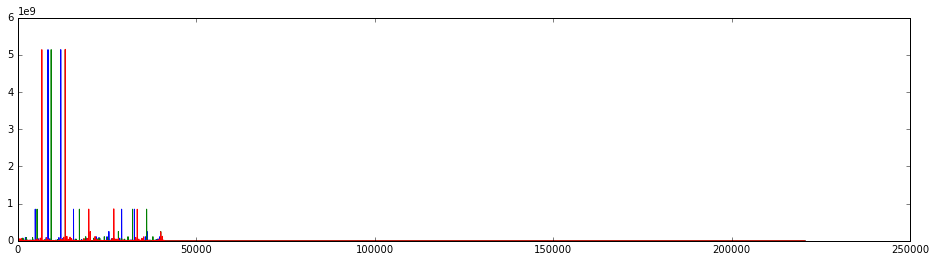

In [13]:
plt.plot(np.abs(np.fft.rfft(channel1)))
plt.plot(np.abs(np.fft.rfft(channel2)))
plt.plot(np.abs(np.fft.rfft(channel3)))

In [14]:
[noise_freq_1, noise_freq_2] = np.argsort(- np.fft.rfft(channel))[:2] / analysis_dt
[noise_freq_1, noise_freq_2]

[852.0, 1209.0]

In [15]:
t = np.linspace(0, analysis_dt, rate * analysis_dt)
channel_sim = np.cos(2 * np.pi * noise_freq_1 * t) + np.cos(2 * np.pi * noise_freq_2 * t)
Audio(channel_sim, rate=rate)

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


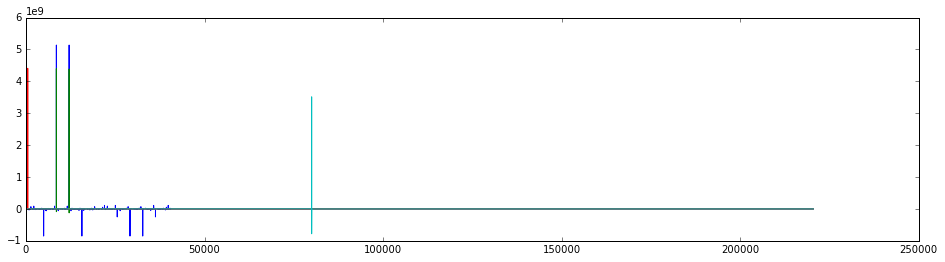

In [16]:
plt.plot(np.fft.rfft(channel))
plt.plot(2e4 * np.fft.rfft(channel_sim))
plt.plot(2e4 * np.fft.rfft(np.cos(2 * np.pi * freq_min * t)))
plt.plot(2e4 * np.fft.rfft(np.cos(2 * np.pi * freq_max * t)))

In [17]:
Audio(np.cos(2 * np.pi * freq_min * t), rate=rate)

In [18]:
Audio(np.cos(2 * np.pi * freq_max * t), rate=rate)

In [19]:
channel_specs = np.sort([freq_min, noise_freq_1, noise_freq_2, freq_max])
channel_ranges = list(zip(channel_specs, channel_specs[1:]))
[range_start, range_end] = max(channel_ranges,key=lambda range:range[1] - range[0])
[range_start, range_end]

[1209.0, 8000.0]

In [20]:
[pulse_freq_1, pulse_freq_d, pulse_freq_2] = np.linspace(range_start, range_end, 3 + 2)[1:-1]
[pulse_freq_1, pulse_freq_d, pulse_freq_2]

[2906.75, 4604.5, 6302.25]

## Pulse design

In [21]:
def design_pulse(sign, freq, pulse_dt, rate, pulse_replicate, pulse_df):
    beta = 0.5
    pulse_t = np.linspace(-pulse_dt * 4 / 2, pulse_dt * 4 /2, rate * pulse_dt)
    
    fp = 4 * beta / (np.pi * np.sqrt(pulse_dt))
    nominF = np.cos((1+beta)* np.pi * pulse_t / pulse_dt) 
    nominS1 = np.sinc((1-beta) * pulse_t / pulse_dt)
    nominS2 = (1-beta) * np.pi / (4 *beta)
    denomin = 1 - np.power(4 * beta * pulse_t / pulse_dt, 2)
    
    out = []
    for value, index in zip(denomin, range(0, len(denomin))):
        if(value == 0):
            out.append(np.cos(2*np.pi * -500 * pulse_t[index])*sign*((np.pi + 2) * np.sin(np.pi / (4 * beta)) + (np.pi - 2)*np.cos(np.pi / (4*beta)))*beta / (np.pi *np.sqrt(2*pulse_dt)))
        else:
            out.append(np.cos(2*np.pi * -500 * pulse_t[index])*sign*fp*(nominF[index] + nominS1[index]*nominS2) /denomin[index])
    return out

In [22]:
pulse_1 = design_pulse(1, pulse_freq_1, pulse_dt, rate, pulse_replicate, pulse_df)
Audio(pulse_1, rate=rate)

In [23]:
pulse_2 = design_pulse(-1, pulse_freq_2, pulse_dt, rate, pulse_replicate, pulse_df)
Audio(pulse_2, rate=rate)

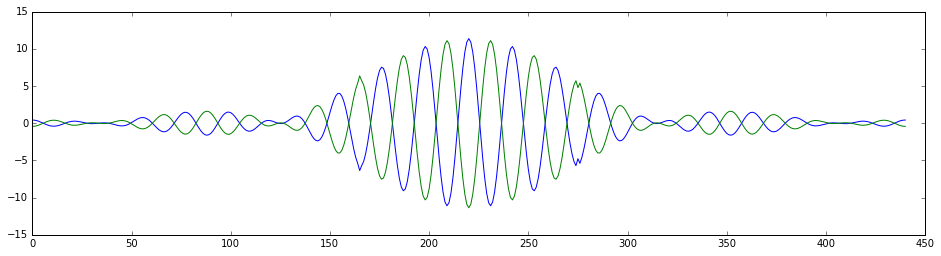

In [24]:
plt.plot(pulse_1[:])
plt.plot(pulse_2[:])

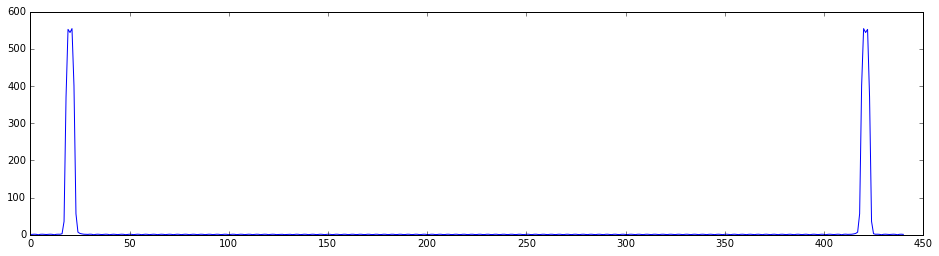

In [25]:
plt.plot(np.abs(np.fft.fft(pulse_1)))

## Emitter

In [26]:
pulse_t = np.linspace(0, pulse_dt, rate * pulse_dt)
delim = np.sin(2 * np.pi * 300 * pulse_t / pulse_dt)
Audio(delim, rate=rate)

In [27]:
textfile = open('textfile.txt', 'r')
message = textfile.read()[:27]
textfile.close()
message = "Top kek patate j'aime pas OS."

In [28]:
message_bin = binarize(message)
assert message == textarize(message_bin)
len(message_bin)

message_bin_redundent = []
for i in message_bin:
    for j in range(0, redundency):
        message_bin_redundent.append(i)


<Container object of 3 artists>

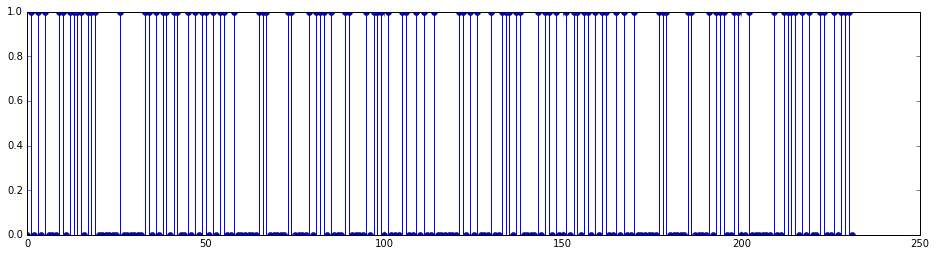

In [29]:
plt.stem(message_bin_redundent)

In [30]:
signal_delay = np.zeros(origin_dt * rate)
signal_delim = delim*10
signal_data = waveform_encoder(message_bin_redundent, pulse_1, pulse_2)
signal = np.concatenate((signal_delay, signal_delim, signal_data, signal_delim, signal_delay))
#sp.io.wavfile.write("trans.wav", rate, signal)
Audio(signal, rate=rate)

In [31]:
signal_t = len(signal) / rate
signal_t

4.34

In [32]:
recorded = signal

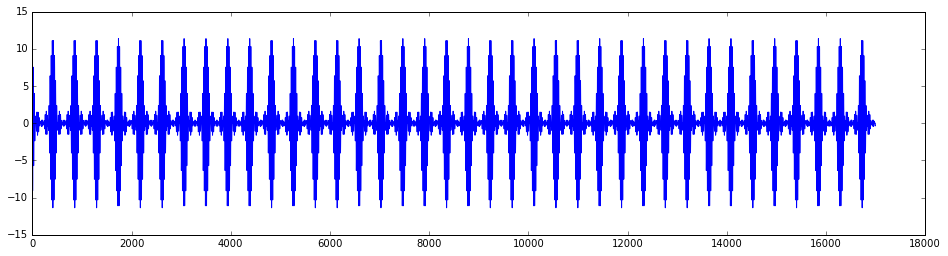

In [33]:
plt.plot(signal[103000:120000])

## Receiver

In [34]:
recorded = record(5, rate)

In [35]:
Audio(recorded, rate=rate)

In [36]:
xcorr = fast_corr(recorded, signal_delim)

In [37]:
mid = len(xcorr) // 2
corr_end = len(xcorr) - np.argmax(xcorr[mid:][::-1])
corr_start = corr_end - len(signal_data) - len(signal_delim) - 1
[corr_start, corr_end]

[79445, 182199]

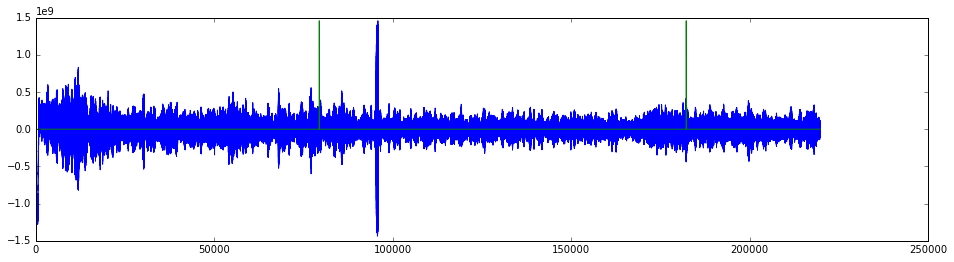

In [38]:
plt.plot(xcorr)
corr_bounds = np.zeros(len(xcorr))
corr_bounds[corr_start] = np.max(xcorr)
corr_bounds[corr_end] = np.max(xcorr)
plt.plot(corr_bounds)

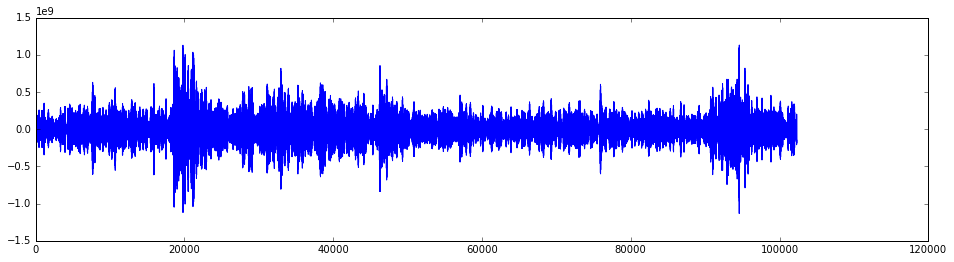

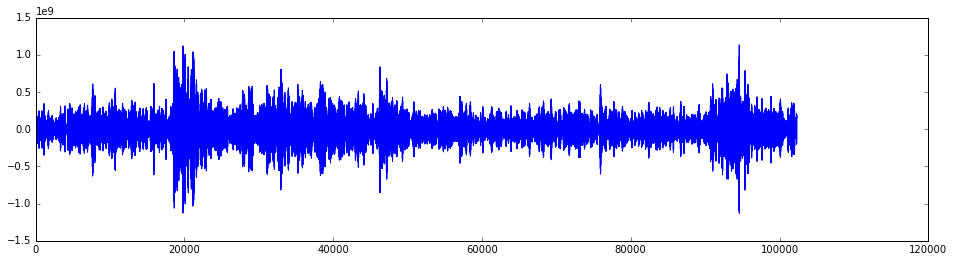

12.6294431761 -12.6294431761
-19.3572178382 19.3572178382
24.6873905608 -24.6873905608
-16.4631452568 16.4631452568
18.3593942939 -18.3593942939
-14.1067793946 14.1067793946
3.23561810981 -3.23561810981
-6.93505945729 6.93505945729
11.7676450107 -11.7676450107
28.335945108 -28.335945108
20.10995145 -20.10995145
12.4160244869 -12.4160244869
-10.3277702643 10.3277702643
10.9692838438 -10.9692838438
-8.01367695815 8.01367695815
6.68360157044 -6.68360157044
-7.6972190591 7.6972190591
3.74532640757 -3.74532640757
33.832885904 -33.832885904
-6.69076501807 6.69076501807
-13.640078218 13.640078218
-10.2606455792 10.2606455792
-12.2916057196 12.2916057196
8.20450484318 -8.20450484318
-3.03413434978 3.03413434978
10.0058844975 -10.0058844975
-17.3858633151 17.3858633151
8.86068584327 -8.86068584327
-5.92062023969 5.92062023969
20.7411283501 -20.7411283501
-13.0205903157 13.0205903157
-8.06065216874 8.06065216874
6.92083074065 -6.92083074065
-12.8775922137 12.8775922137
18.8866244025 -18.88662440

In [39]:
received_window = recorded[corr_start:corr_end]
received_align = match_decoder(received_window, pulse_1, pulse_2, rate * pulse_dt, True, plot=True)
received = received_align[1:]

<Container object of 3 artists>

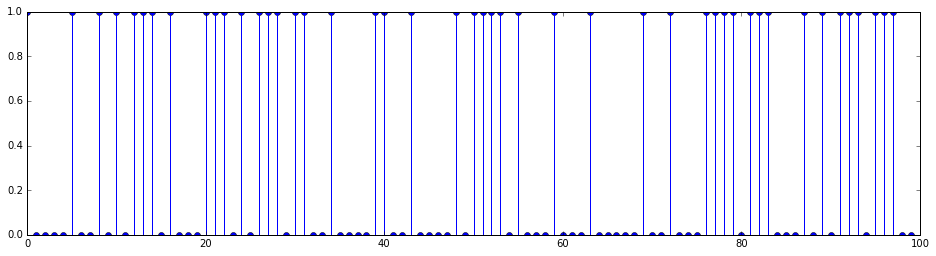

In [40]:
plt.stem(received[100:200])

In [41]:
remove_redundency = []
for i in range(0, len(received) // redundency):
    tmp = []
    for j in range (0, redundency):
        tmp.append(received[i*redundency: i * redundency + redundency])
    median = np.median(tmp)
    assert int(median) == median
    remove_redundency.append(int(median))
received = remove_redundency

In [42]:
for i in range(0,8):
    print(str(i) + ':  ' + textarize(received[i:]))
          
len(received)

0:  UêÂ©JaØLÐèJèë²ÑH÷Üki.
1:  «ÕRÃ° ÐÑ×d2¢ î+¸ÖÒ .
2:  W«
¥)`12@3¡+£®Èd/DA#ÜWq­¤@.
3:  ¯VJSÀbdgBWG]È^G¸®ã[H
 Î®»!½q]Æ¶
5:  ½XU)L;	]vC!z"	â»m"
6:  z°ªRv 4:º:ìBôD=ÅwÚD
7:  õaT¥0ì&@ht%tuÙè${î5´ 


232

In [74]:
dt = 0.01

In [75]:
rate = 44100

In [76]:
T = dt / 2

In [77]:
beta = 0.5

In [78]:
t = np.linspace(- T, T, 2 * T * rate)

In [82]:
hosp = T / (4 * beta)

In [ ]:
p = np.zeros(len(t))

In [85]:
p += (1 - np.isclose(hosp, t)) * (4 * beta  * np.cos((1 + beta) * np.pi * t / T) + np.sin((1 - beta) * np.pi  * t / T) / t)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


ValueError: operands could not be broadcast together with shapes (6615000,) (441,) (6615000,) 

In [ ]:
P += (1 - np.isclose(hosp, t)) / (np.pi * np.sqrt(T) * (1 - ))

In [48]:
t = np.linspace(- , b2, 2 * b2 * rate)

In [49]:
p = (np.abs(f) <= b1) + (np.abs(f) > b1) * np.cos(np.pi * dt * (np.abs(f) - b1) / (2 * beta))

In [83]:
1-np.isclose(1, 1.00000001)

0

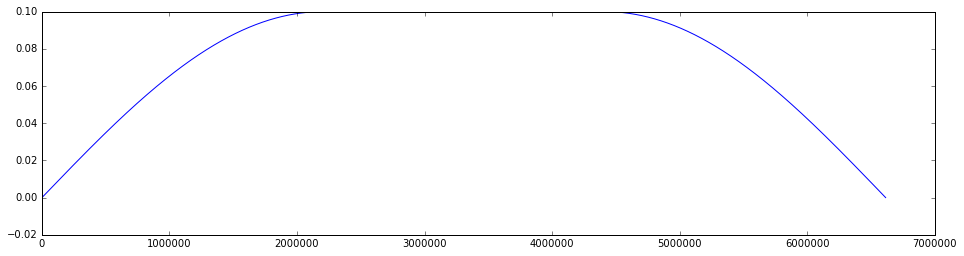

In [51]:
plt.plot(p)

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


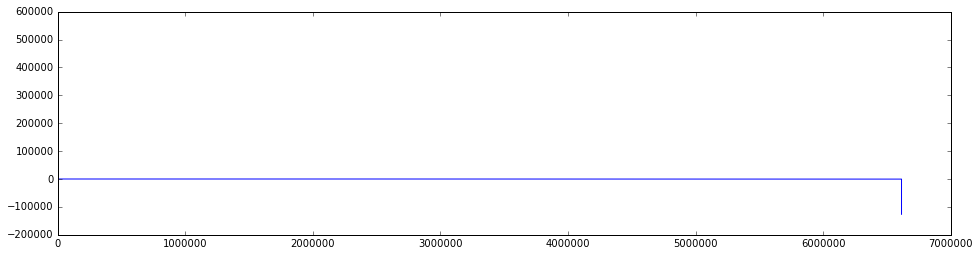

In [56]:
plt.plot(np.fft.fft(p))

In [412]:
def design_pulse(freq, pulse_dt, rate, width=1, beta=0.5):
    np.seterr(invalid='ignore')
    pulse_t = np.linspace(0, pulse_dt * width, rate * pulse_dt)
    
    p_const = 4 * beta / (np.pi * np.sqrt(pulse_dt))
    p_cos = np.cos((1 + beta) * np.pi * pulse_t / pulse_dt) 
    p_sinc = (1 - beta) * np.pi / (4 * beta) * np.sinc((1 - beta) * pulse_t / pulse_dt)
    p_denomin = 1 - (4 * beta * pulse_t / pulse_dt) ** 2
    p_hosp = beta / (np.pi * np.sqrt(2 * pulse_dt)) * ((np.pi + 2) * np.sin(np.pi / (4 * beta)) + (np.pi - 2) * np.cos(np.pi / (4 * beta)))
        
    out = p_const * (p_cos + p_sinc) / p_denomin
    out[np.isnan(out)] = p_hosp
    out *= np.cos(2 * np.pi * freq * pulse_t)
    
    assert not any(np.isnan(out))    
    np.seterr(invalid='warn')
    return out

In [468]:
p_0 = design_pulse(750, 0.01, rate, 2)
p_1 = design_pulse(1000, 0.01, rate, 2)
p_2 = design_pulse(1250, 0.01, rate, 2)

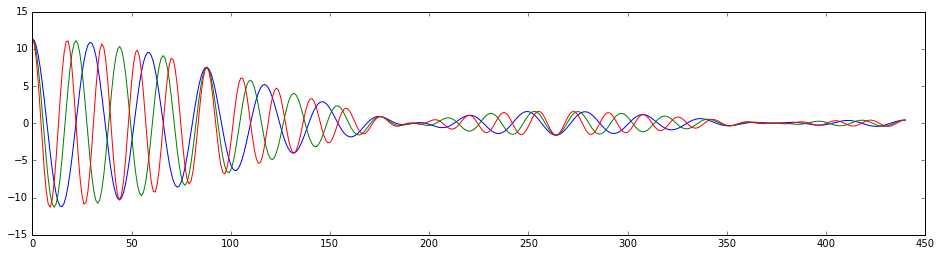

In [469]:
plt.plot(p_0)
plt.plot(p_1)
plt.plot(p_2)

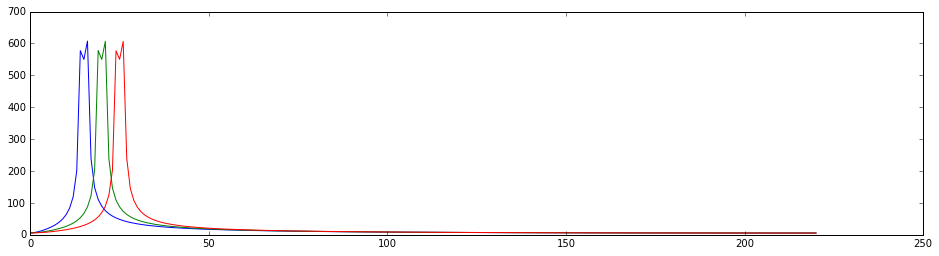

In [470]:
plt.plot(np.abs(np.fft.rfft(p_0)))
plt.plot(np.abs(np.fft.rfft(p_1)))
plt.plot(np.abs(np.fft.rfft(p_2)))

In [471]:
Audio(p_2, rate=rate)

In [472]:
Audio(p_0 + p_1, rate=rate)

In [473]:
Audio(p_0 + p_1 + p_2, rate=rate)

In [53]:
print(len(lcs(received, message_bin)))
for x, y in zip(message_bin, received):
    print(str(x) + " " + str(y))


14
0 0
1 1
0 0
1 1
0 0
1 1
0 0
0 1
0 1
1 1
1 1
0 0
1 1
1 0
1 1
1 0
0 1
1 1
1 0
1 0
0 0
0 0
0 1
0 0
0 1
0 0
1 1
0 0
0 1
0 0
0 0
0 1
0 0
1 1
1 0
0 0
1 1
0 0
1 1
1 0
0 0
1 1
1 1
0 0
0 0
1 0
0 0
1 1
0 1
1 1
1 0
0 1
1 1
0 0
1 0
1 0
0 0
0 0
1 0
0 0
0 1
0 1
0 0
0 0
0 0
1 1
1 0
1 0
0 1
0 1
0 0
0 0
0 1
1 0
1 0
0 0
0 0
0 0
0 0
1 0
0 1
1 1
1 0
1 1
0 0
1 0
0 0
0 0
0 0
1 0
1 0
0 0
0 1
0 1
0 0
1 0
0 1
1 1
1 1
1 0
0 1
1 0
0 0
0 0
0 0
1 1
1 0
0 0
0 1
1 0
0 1
1 0
0 1
0 1
1 1
0 0
0 1
0 0
0 0
0 0
0 1
1 1
1 1
0 0
1 1
0 0
1 1
0 1
0 1
0 0
1 1
0 1
0 0
1 0
1 1
1 0
0 0
1 0
1 0
0 1
0 1
0 0
0 0
1 1
0 0
1 0
1 0
0 0
1 1
0 0
0 1
1 1
0 1
1 1
1 0
0 1
1 0
1 0
0 0
1 1
0 0
1 0
1 0
0 1
0 0
1 0
0 0
1 0
0 0
0 1
1 0
0 0
0 1
0 0
0 0
0 0
0 1
1 1
1 1
1 1
0 0
0 1
0 1
0 1
0 0
1 0
1 0
0 1
0 0
0 1
0 0
1 1
0 1
1 1
1 0
1 1
0 1
0 1
1 0
1 0
0 0
0 1
1 1
0 0
0 1
0 0
0 1
0 1
0 0
1 1
0 1
0 0
1 1
1 0
1 0
1 1
0 0
1 0
0 0
1 1
0 0
0 0
1 0
1 0
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
